### Load standard libraries



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import glob
from collections import Counter
import seaborn as sns
import os

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

from scipy.stats import linregress
from skimage.transform import rescale

### Load data
The data is Google Drive's fontclosgpu@gmail.com account. We **mount** the drive and untar the data in the ephemeral Google Colab instance we have been given.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Set basedir where we are going to operate

In [3]:
BASEDIR = Path("/content/drive/MyDrive/silicanets-data/")

We first read just the metadata, which has paths to images and targets. This is enough to do data resmapling to turn the target uniform and train validation test splitting.

### Set global parameters
Here we choose the number of runs, number of samples, max training epochs and dropout level.

In [4]:
# choose training dataset
training_data_disorder_variance = "variable"

if isinstance(training_data_disorder_variance, float):
  varcode = str(int(10 * training_data_disorder_variance))
  compressed_data = f"ml_dataset_var0{varcode}.tar.gz"

elif training_data_disorder_variance == "variable":
  compressed_data = "ml_dataset_variable_var.tar.gz"

else:
  raise NotImplementedError


try:
  df = pd.read_csv("ml_dataset/metadata.csv")
except:
  ! tar xzf {BASEDIR / "data" / compressed_data}
  df = pd.read_csv("ml_dataset/metadata.csv")

#assert len(df)==len([name for name in os.listdir('ml_dataset/images') if os.path.isfile(os.path.join('ml_dataset/images', name))])
try:
  del history_df
except:
  pass


num_samples = "all" # a number or "all"
num_runs = "all" # a number or "all"
max_epochs = 100
dropout = 0
scale = 0.5

# for the lazy types
if num_samples == "all":
  num_samples = len(df)
if num_runs == "all":
  num_runs = len(df.run.unique())

assert num_runs <= len(df.run.unique())


In [5]:
print(len(df))

38912


In [6]:
print(len([name for name in os.listdir('ml_dataset/images') if os.path.isfile(os.path.join('ml_dataset/images', name))]))

77824


In [7]:
if training_data_disorder_variance == "variable":
  disorder_df = pd.read_csv(BASEDIR / "data" / "variable_disorder_missing_metadata_column.txt", header=None, sep=" ", names=["run", "disorder"])
  disorder_df["run"] = disorder_df.run.apply(lambda x: f"run_{x:05d}")
  df["disorder_var"] = df.run.map(dict(disorder_df.values))

### Subsample data
Because the distribution of failure strain is approx gaussian, the model tends to predict average failure strain (similar to class imbalance problem). Given that we have access to unlimited amounts of data (in the form of data augmentation but if needed we could also run more simulations), what we do is to select a different number of images from each run, in a way that the final density of target is closer to uniform.

First select a subset of runs, this is just to study the effect of number of runs on final accuracy

In [8]:
assert num_runs <= len(df.run.unique())
valid_runs = np.random.choice(df.run.unique(), size=num_runs, replace=False)
_idx = df.run.apply(lambda x: x in valid_runs)
df = df.loc[_idx].copy()

Then do the proper data-augmentation level subsampling to render the target uniform.

In [9]:
df_subsampled = df.sample(num_samples)

### Create output dir
Create a new, unique directory to store all outputs of this round.

In [10]:
import datetime
model_name = "resnet-disorder-" + datetime.datetime.now().isoformat().split(".")[0]
! mkdir -p {BASEDIR / "output" / model_name / "checkpoints"}
! mkdir -p {BASEDIR / "output" / model_name / "dataframes"}
! mkdir -p {BASEDIR / "output" / model_name / "figures"}




Save dfs for reproducibility

In [11]:
pd.to_pickle(df, BASEDIR / "output" / model_name / "dataframes" / "df.p")
pd.to_pickle(df_subsampled, BASEDIR / "output" / model_name / "dataframes" / "df_subsampled.p")

In [12]:
num_runs = len(df_subsampled.run.unique())
num_images = len(df_subsampled)

In [13]:
info = {
    "model_name": model_name,
    "num_runs": num_runs,
    "num_images": num_images,
    "max_epochs": max_epochs,
    "dropout": dropout,
    "scale": scale,
    "disorder_variance": training_data_disorder_variance,
    "loss": "mse"
}

In [14]:
pd.Series(info).to_csv(BASEDIR / "output" / model_name / "model_info.csv")

In [15]:
info

{'disorder_variance': 'variable',
 'dropout': 0,
 'loss': 'mse',
 'max_epochs': 100,
 'model_name': 'resnet-disorder-2022-02-22T13:56:28',
 'num_images': 38912,
 'num_runs': 608,
 'scale': 0.5}

### Split data
We need to split the data into the standard train, validation, test sets, but respecting the original runs (otherwise we have copies of same run in different sets which is not ok)

In [16]:
def data_splitter(df, test_split=0.2):
  """Split the metadata dataframe into train and test sets
  keeping runs together, that is, not allowing different images
  of the same run to be in different sets.
  """
  runs_all = df["run"].unique()
  _run_splitter = int((1 - test_split) * len(runs_all))
  np.random.shuffle(runs_all)
  runs_train = runs_all[:_run_splitter]
  runs_test = runs_all[_run_splitter:]
  _idx_train = df.run.apply(lambda x: x in runs_train)
  _idx_test = df.run.apply(lambda x: x in runs_test)
  df_train = df.loc[_idx_train]
  df_test = df.loc[_idx_test]

  return df_train, df_test

In [17]:
df_train, df_test = data_splitter(df_subsampled, test_split = 0.2)
df_train, df_validation = data_splitter(df_train, test_split=0.1)

In [18]:
print(f"Saving metadata of train, test, validation for reproducibility:")
print(f"Train set: {len(df_train.run.unique())} runs ({len(df_train)} images)")
print(f"Validation set: {len(df_validation.run.unique())} runs ({len(df_validation)} images)")
print(f"Test set: {len(df_test.run.unique())} runs ({len(df_test)} images)")

df_train.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_train.p")
df_validation.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_validation.p")
df_test.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_test.p")

Saving metadata of train, test, validation for reproducibility:
Train set: 437 runs (27968 images)
Validation set: 49 runs (3136 images)
Test set: 122 runs (7808 images)


### Load images
We load all images into memory. 
So far this works, but we are close to our memory limits.
We might need to use keras DataGenerators in the future.

In [20]:
def get_xy_from_df(df, scale: float=1.0):
    X = []
    y = []
    for _, sample in df.iterrows():
        _X = rescale(plt.imread(sample["image"]), scale=scale)
        _y = [sample["disorder_var"]]
        X.append(_X)
        y.append(_y)
    X = np.array(X)
    y = np.array(y)
    X = np.expand_dims(X, -1)
    return X, y

In [21]:
X_train, y_train = get_xy_from_df(df_train, scale=scale)
X_validation, y_validation = get_xy_from_df(df_validation, scale=scale)
X_test, y_test = get_xy_from_df(df_test, scale=scale)

### Feature normalization
We rescale features and targets using train test to learn only to avoid data leaking.

In [22]:
_m = np.mean(X_train, axis=0)
_s = np.std(X_train, axis=0)

X_train = ((X_train - _m) / _s)
X_validation = ((X_validation - _m) / _s)
X_test =  ((X_test - _m) / _s)

In [23]:
train_data_rescale_params = {
    "mean": _m,
    "std": _s
}
pd.to_pickle(train_data_rescale_params, BASEDIR / "output" / model_name / "dataframes" / "train_data_rescale_params.p")

In [24]:
pd.to_pickle(X_train, BASEDIR / "output" / model_name / "dataframes" / "X_train.p")
pd.to_pickle(X_validation, BASEDIR / "output" / model_name / "dataframes" / "X_validation.p")
pd.to_pickle(X_test, BASEDIR / "output" / model_name / "dataframes" / "X_test.p")

pd.to_pickle(y_train, BASEDIR / "output" / model_name / "dataframes" / "y_train.p")
pd.to_pickle(y_validation, BASEDIR / "output" / model_name / "dataframes" / "y_validation.p")
pd.to_pickle(y_test, BASEDIR / "output" / model_name / "dataframes" / "y_test.p")

### Crash recover
Uncomment this cell and run to recover from a crash after training.
Remember to skip training if you do this!

In [ ]:
if False:
  model_name = ""

  df = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df.p")
  df_subsampled = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_subsampled.p")
  df_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_train.p")
  df_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_validation.p")
  df_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_test.p")


  X_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_train.p")
  X_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_validation.p")
  X_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_test.p")

  y_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_train.p")
  y_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_validation.p")
  y_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_test.p")

  history_df = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "history_df.p")

  # recover important settings
  info = dict(pd.read_csv(BASEDIR / "output" / model_name / "model_info.csv").values)
  dropout = float(info["dropout"])
  try:
    training_data_disorder_variance = float(info["disorder_variance"])
  except:
    training_data_disorder_variance = str(info["disorder_variance"])



### Model setup
We use a simple keras + dropout + dense scheme.

In [26]:
def get_model(dropout: float = 0.0):
  premaid = tf.keras.applications.ResNet50(
      include_top=False,
      pooling="avg",
      weights=None,
      input_shape=X_train[0].shape,
  )

  model = tf.keras.models.Sequential()
  model.add(premaid)
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss="mean_squared_error", optimizer="adam")
  return model

In [27]:
model = get_model()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23581440  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,583,489
Trainable params: 23,530,369
Non-trainable params: 53,120
_________________________________________________________________


### Model training
We train for a few epochs, saving weights of best epoch.



In [29]:
checkpoint_filepath = BASEDIR / "output" / model_name / "checkpoints" 

In [30]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True,
        ),
]

In [31]:
history = model.fit(
    X_train, y_train,
    validation_data = (X_validation, y_validation),
    epochs=20, #max_epochs,
    callbacks=callbacks
)
try:
  history_df = pd.concat([history_df, pd.DataFrame(history.history)])
  history_df.index = range(len(history_df))
except:
  history_df = pd.DataFrame(history.history)

# save history df
history_df.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "history_df.p")

Epoch 1/20
874/874 [==============================] - 125s 126ms/step - loss: 0.7388 - val_loss: 0.4442
Epoch 2/20
874/874 [==============================] - 114s 130ms/step - loss: 0.0371 - val_loss: 0.1817
Epoch 3/20
874/874 [==============================] - 114s 130ms/step - loss: 0.0319 - val_loss: 0.0147
Epoch 4/20
874/874 [==============================] - 113s 129ms/step - loss: 0.0291 - val_loss: 0.0466
Epoch 5/20
874/874 [==============================] - 113s 130ms/step - loss: 0.0238 - val_loss: 0.0065
Epoch 6/20
874/874 [==============================] - 113s 129ms/step - loss: 0.0279 - val_loss: 0.0147
Epoch 7/20
874/874 [==============================] - 115s 131ms/step - loss: 0.0206 - val_loss: 0.0055
Epoch 8/20
874/874 [==============================] - 113s 129ms/step - loss: 0.0229 - val_loss: 0.0152
Epoch 9/20
874/874 [==============================] - 113s 129ms/step - loss: 0.0201 - val_loss: 0.0697
Epoch 10/20
874/874 [==============================] - 113s 129m

### Model predictions
We load the best weights and do predictions

In [32]:
model.load_weights(checkpoint_filepath)

In [33]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [34]:
raw_results_df_test = df_test.copy()
raw_results_df_test["target"] = y_test.T[0]
raw_results_df_test["prediction"] = y_test_pred.T[0]
results_df_test = raw_results_df_test.groupby("run").median().reset_index()

In [35]:
raw_results_df_train = df_train.copy()
raw_results_df_train["target"] = y_train.T[0]
raw_results_df_train["prediction"] = y_train_pred.T[0]
results_df_train = raw_results_df_train.groupby("run").median().reset_index()

### Save model predictions

In [36]:
raw_results_df_train.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "raw_results_df_train.p")
raw_results_df_test.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "raw_results_df_test.p")
results_df_train.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "results_df_train.p")
results_df_test.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "results_df_test.p")

### Plot results

In [37]:
def plot_resampling():
  fig, ax = plt.subplots(1, 1, figsize=(5, 4))
  a, b = 0.03, 0.22
  bins = np.linspace(a, b)
  ax.hist(df.break_strain, bins=bins, density=False, color="0.2", histtype="step", ls="dashed", label="Original")
  ax.hist(df.break_strain, bins=bins, density=False, color="0.2", alpha=0.1)
  ax.hist(df_subsampled.break_strain, bins=bins, density=False, color="blue", alpha=1, histtype="step", lw=2, label="Resampled")
  ax.hist(df_subsampled.break_strain, bins=bins, density=False, color="blue", alpha=0.2)
  ax.set_xlim(a, b)
  ax.set_xlabel("Rupture strain")
  ax.legend()
  return fig, ax

In [38]:
def plot_results(results_df: pd.DataFrame, label="LABEL"):
  x, y = results_df.target, results_df.prediction
  R2 = linregress(x, y).rvalue ** 2

  fig, ax = plt.subplots(1, 1, figsize=(5, 4))
  a = np.min([np.min(x), np.min(y)])
  b = np.max([np.max(y), np.max(y)])  

  sns.regplot(x, y, ax=ax, truncate=False, color=colors_dict[label])
  
  ax.set_xlabel("Sample disorder")
  ax.set_ylabel("Model prediction")

  ax.plot([a, b], [a, b], ls="dashed", c="0.2")
  ax.set_aspect(1)
  ax.text(0.1, 0.95, f"$R^2 = {R2:.2f}$\n{label}", fontsize=14, transform=ax.transAxes, va="top", ha="left")
  return fig, ax

In [39]:
def plot_errors(results_df: pd.DataFrame, label="LABEL"):
  percent_error = (results_df.prediction / results_df.target - 1) * 100
  fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
  sns.distplot(percent_error, ax=ax, label="Ensemble pred", hist=True, color=colors_dict[label])
  xticks = ax.get_xticks()
  ax.set_xticks(xticks)
  ax.text(0.05, 0.9, label, transform=ax.transAxes, fontsize=14)  
  xticklabels = [f"{int(x)}%" for x in xticks]
  ax.set_xticklabels(xticklabels)
  ax.set_xlabel("Relative error")
  return fig, ax

In [40]:
def plot_history(history_df: pd.DataFrame):
  fig, ax = plt.subplots(1, 1, figsize=(5, 4))
  ax.plot(history_df.loss, marker="o", ms=7, label="Train set", color=colors_dict["TRAIN SET"])
  ax.plot(history_df.val_loss, marker="o", ms=7, label="Validation set", color=colors_dict["VALIDATION SET"])
  ax.legend(frameon=False)
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss function (MSE)")
  ax.set_yscale("log")
  return fig, ax

In [41]:
colors_dict = {
    "TRAIN SET":"0.5",
    "VALIDATION SET": "#ff2d55",
    "TEST SET": "#007aff",
}

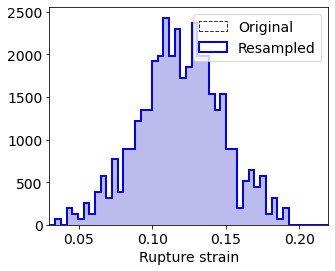

In [42]:
fig, ax = plot_resampling()
fig.savefig(BASEDIR / "output" / model_name / "figures" / "rupture_strain_resampling.png", dpi=150)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


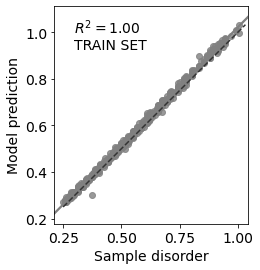

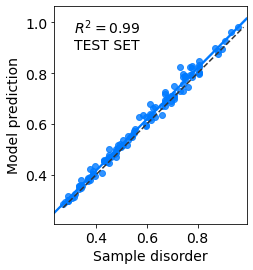

In [43]:
fig, ax = plot_results(results_df=results_df_train, label="TRAIN SET")
ax.set_aspect(1)
fig.savefig(BASEDIR / "output" / model_name / "figures" / "results_train_set.png", dpi=150)

fig, ax = plot_results(results_df=results_df_test, label="TEST SET")
ax.set_aspect(1)
fig.savefig(BASEDIR / "output" / model_name / "figures" / "results_test_set.png", dpi=150)

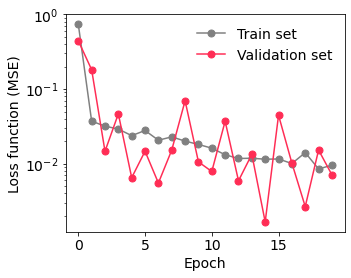

In [44]:
fig, ax = plot_history(history_df=history_df)
fig.savefig(BASEDIR / "output" / model_name / "figures" / "loss_function.png", dpi=150)